In [ ]:
"""
input:
    - main_configs.json
    - combined_socio_economic_parameters.parquet
    - 
output:
    - figure2F.svg
    - univariate_significance_table.xlsx
    - socio_economic_params_coeff_hist.pdf
    - figure2E.svg
"""

In [2]:
import os
import json
import scipy
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import matplotlib.transforms as transforms
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression

from src.scripts.common_figures import Figures

import warnings
warnings.filterwarnings("ignore")

In [3]:
with open("/src/main_configs.json", 'r') as f:
    main_configs = json.load(f)

supp_figures_path = "/figures/experimental/supp_figures"
main_figures_path = "/figures/experimental/main_figures"
dataframes_path = "/data/processed/dataframes"

figures = Figures()

In [6]:
combined_df = pd.read_parquet(f"{dataframes_path}/combined_socio_economic_parameters.parquet")
combined_df.head()

,state,nonnative_perc,plths_perc,pgtbch_perc,unemployment_perc,median_household,poverty_perc,black_perc,president,social_capita,cat_dog_ratio,tweet_counts,odd_ratios
0,AK,0.033097,0.355479,0.318555,0.081370,80197,0.091525,0.029367,0.100612,0.39,-0.362661,657,0.471756
1,AL,0.020432,0.411211,0.278057,0.059426,53956,0.146839,0.251810,0.254617,-0.94,-0.586082,3779,-0.100419
2,AR,0.031001,0.462472,0.248960,0.064616,51183,0.153317,0.145029,0.276207,-1.29,-0.393904,2246,-0.208552
3,AZ,0.062468,0.343174,0.329732,0.065186,64777,0.127909,0.046272,-0.003087,-1.33,-0.487836,8280,-0.253782
4,CA,0.117392,0.352820,0.369291,0.082017,83056,0.114284,0.055902,-0.291632,-0.85,-0.147567,44623,0.171503


In [7]:
sc = StandardScaler()

X_std = combined_df.drop(columns=['state', 'tweet_counts', 'odd_ratios']).values
X_std = sc.fit_transform(X_std)
y = combined_df['odd_ratios'].values

In [9]:
columns = combined_df.drop(columns=['state', 'tweet_counts', 'odd_ratios']).columns

df_coef = list()
i = np.arange(50)
for _ in tqdm(range(10000)):
    selected_idx = np.random.choice(i, np.random.randint(20, 50))
    X_subset = X_std[selected_idx]
    y_subset = y[selected_idx]
    pls2 = PLSRegression(n_components=X_std.shape[1])
    pls2.fit(X_subset, y_subset)
    df_coef.append(pls2.coef_.ravel())

df_coef = pd.DataFrame(df_coef, columns=columns)

100%|██████████| 10000/10000 [00:32<00:00, 309.90it/s]


In [10]:
univariate_coef = []
for idx in range(10):
    concated_xy = np.concatenate([X_std[:, idx].reshape(-1, 1), y.reshape(-1, 1)], axis=1)
    correlation = scipy.stats.spearmanr(concated_xy)
    univariate_coef.append(correlation.correlation)

df_coef_univariate = pd.DataFrame(np.array(univariate_coef).reshape(1,-1), columns=columns)

In [11]:
df_coef.columns = main_configs['socio_economic_params_abbr']
df_coef_univariate.columns = main_configs['socio_economic_params_abbr']

In [12]:
df_coef.head()

,Non-native,Education1,Education2,Unemployment,Median Income,Poverty,Black Percentage,Election,Per Capita Income,$log(Cat/Dog)$
0,-0.164608,-0.182218,-0.222268,-0.079922,0.356905,0.305278,-0.075937,-0.251663,0.032809,-0.007459
1,-0.103872,-0.074053,-0.156055,0.005188,0.188586,0.078257,-0.072539,-0.118621,0.094256,-0.011416
2,0.054473,0.084785,0.169860,-0.135704,0.158253,0.282634,0.035525,-0.066403,0.152596,0.135182
3,0.042329,0.096575,-0.093570,-0.054867,0.030353,0.142171,-0.018657,-0.287818,0.317831,-0.085401
4,0.041499,0.099805,-0.029302,-0.147980,0.149146,0.206864,-0.033883,-0.311222,0.231587,0.011942


In [13]:
df_coef_univariate.head()

,Non-native,Education1,Education2,Unemployment,Median Income,Poverty,Black Percentage,Election,Per Capita Income,$log(Cat/Dog)$
0,0.045858,-0.486291,0.517311,-0.194622,0.492149,-0.549292,-0.392269,-0.45114,0.556151,0.455366


In [14]:
columns_plt = df_coef.columns

In [15]:
import math
def ci(r):
    num = 50
    stderr = 1.0 / math.sqrt(num - 3)
    delta = 2.576 * stderr
    lower = math.tanh(math.atanh(r) - delta)
    upper = math.tanh(math.atanh(r) + delta)
    return [lower, upper]

In [16]:
mean_of_features = df_coef.mean(axis=0).reset_index(name='mean')
errors = np.array([[np.quantile(df_coef[i], .005), np.quantile(df_coef[i], .995)] for i in df_coef.columns])

errors_univariate = np.array([ci(i) for i in df_coef_univariate.iloc[0, :].values])

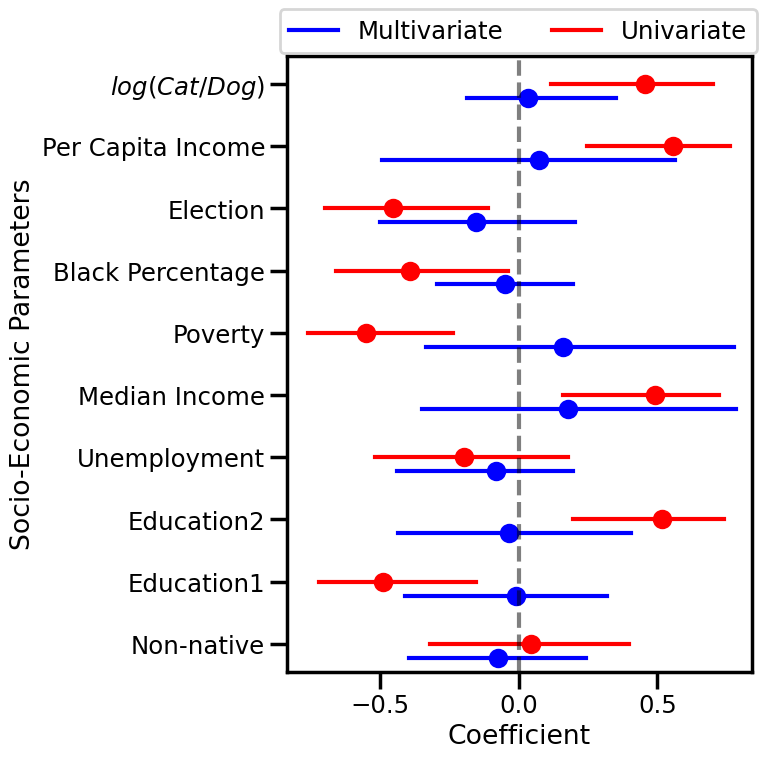

In [18]:
sns.set_context('poster', 0.8)

plt.figure(figsize=(6, 8))
offset = lambda p: transforms.ScaledTranslation(0, p/72., plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

for idx in range(len(errors)):
    plt.plot(errors[idx], [columns_plt[idx]]*2, c='blue', transform=trans+offset(-10))
    plt.plot(errors_univariate[idx], [columns_plt[idx]]*2, c='red')

plt.scatter(x=mean_of_features['mean'].values, y=columns_plt, c='blue', transform=trans+offset(-10))
plt.scatter(x=df_coef_univariate.iloc[0, :].values, y=columns_plt, c='red')
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
plt.ylabel("Socio-Economic Parameters")
plt.xlabel("Coefficient")
plt.legend(['Multivariate', 'Univariate'], loc=[-0.015, 1.005], ncol=2)

plt.savefig(f"{main_figures_path}/figure2F.svg", bbox_inches='tight')
plt.show()

In [ ]:
significance_table = []

for idx in range(len(errors)):
    is_significant = np.all(np.array(errors_univariate[idx]) > 0) or np.all(np.array(errors_univariate[idx]) < 0)
    significance_table.append([columns_plt[idx], is_significant])

significance_table = pd.DataFrame(significance_table, columns=['Parameter Name', 'Is Significant'])

In [ ]:
supp_tables_path = "/data/processed/supp_tables"
os.makedirs(supp_tables_path, exist_ok=True)

significance_table.to_excel(f"{supp_tables_path}/univariate_significance_table.xlsx", index=False)

## Distributions

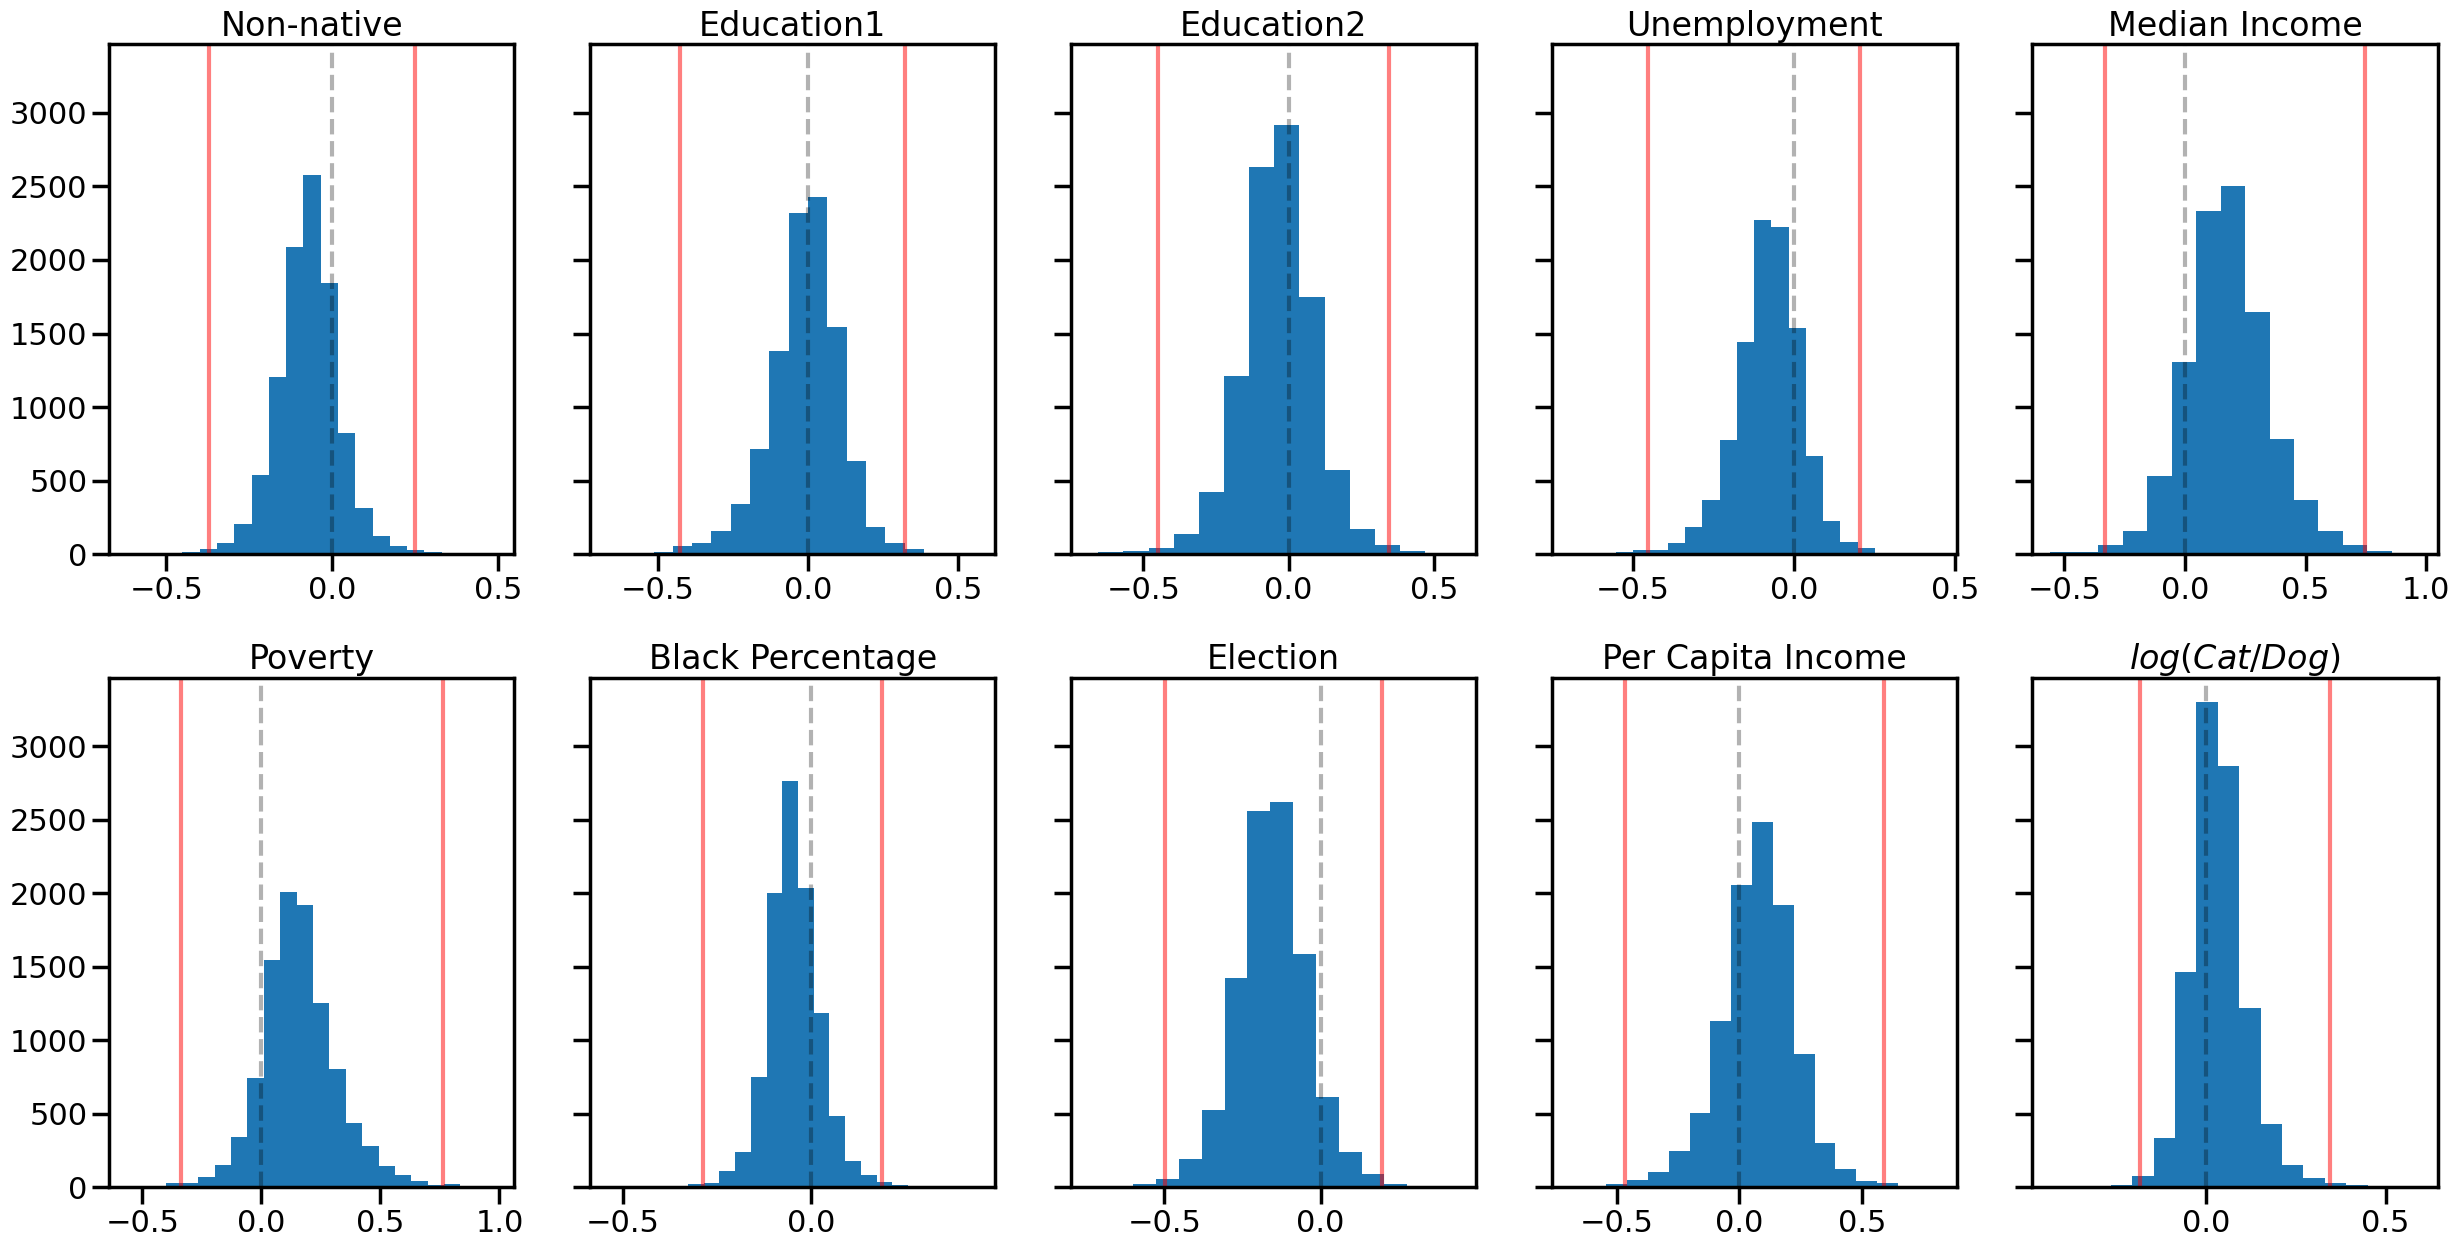

In [ ]:
sns.set_context('poster', 1)

fig, ax = plt.subplots(2, 5, figsize=(25, 13), sharey=True)
for idx, i in enumerate(df_coef.columns):
    ax_idx = (idx//5, idx%5)
    ax[ax_idx].set_title(i)
    hist, bin_edges, patches = ax[ax_idx].hist(df_coef[i], 30)
    ax[ax_idx].axvline(0, color='black', alpha=0.3, linestyle='--')
    
    secondq, firstq  = errors[idx]
    ax[ax_idx].axvline(firstq, color='red', alpha=0.5)
    ax[ax_idx].axvline(secondq, color='red', alpha=0.5)
    ax[ax_idx].set_xlim([secondq-0.3, firstq+0.3])

fig.tight_layout()
plt.savefig(f"{supp_figures_path}/socio_economic_params_coeff_hist.pdf")
plt.show()

### Correlation Figure

In [ ]:
loo = LeaveOneOut()

y_preds = []
for train_index, test_index in loo.split(X_std):
    X_train, X_test = X_std[train_index], X_std[test_index]
    y_train, y_test = y[train_index], y[test_index]

    pls = PLSRegression(n_components=X_train.shape[1])
    pls = PLSRegression(n_components=1)
    pls.fit(X_train, y_train)
    y_pred = pls.predict(X_test)

    y_preds.append(y_pred)

df = pd.DataFrame({'y_true':y, 'y_pred':np.ravel(y_preds),
                'state':combined_df['state'].values, 'tweet_counts':combined_df['tweet_counts'].values})

In [ ]:
r2_score(df['y_true'].values, df['y_pred'].values)

0.314013918116271

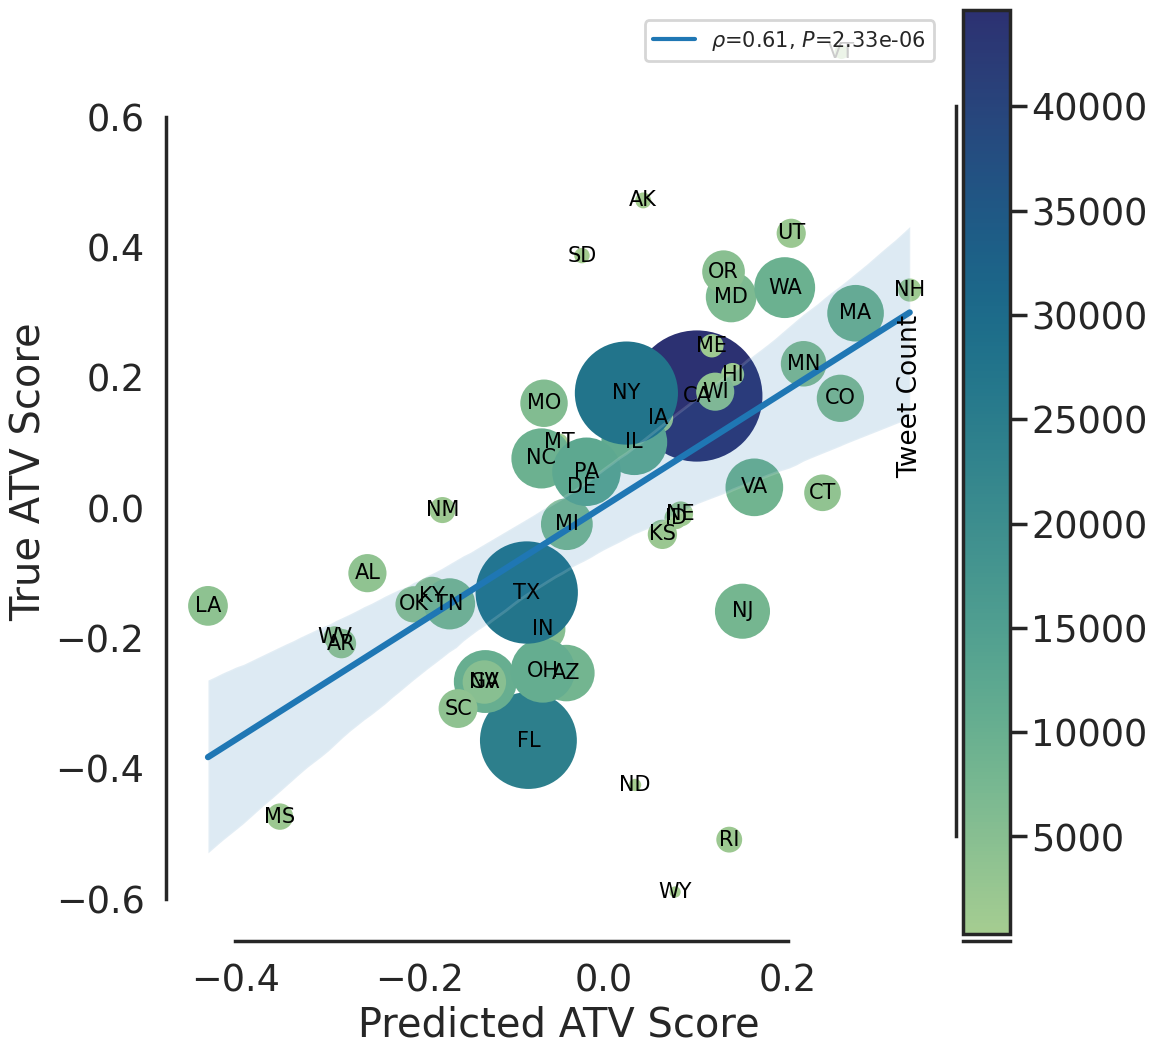

In [ ]:
sns.set_context('poster', 1.2)

save = f"{main_figures_path}/figure2E.svg"
figures.draw_correlation_figure(df, 'y_pred', 'y_true',
                                'Predicted ATV Score', 'True ATV Score', figsize=(12, 12),
                                point_size_multiplexer=0.2, save=None, paper_figure=save)